In [1]:
import os
import sys
sys.path.append(os.path.abspath('repo/trans_probs/mvp/'))


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import math
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.interpolate import BSpline
from IPython.display import display, Markdown, Latex
from models import *
import re

In [3]:
# parameters for experiments displayed
# data types
data_types = [1]
# to be changed later
experiments = ['norm1_crossent_comp', 'norm1_crossent_bet','norm1_crossent_simp', 'norm1_exp_comp', 'norm1_exp_bet', 'norm1_exp_simp']
# experiments = ['crossent_simp']
turns = ['b0', 'b1', 'b2']

In [4]:
def get_prep_type(exp_name):
    '''
    Description: uses the experiment name to determine
    where to load data from
    '''
    # grab prep type (the integer contained in the
    # experiment name)
    prep_type = re.findall(r'\d+', exp_name)
    prep_type = prep_type[0]
    prep_type = int(prep_type)

    if int(prep_type) == 1:
        if 'norm' in exp_name:
            prep_type = 'norm1'
        else:
            prep_type = 'mvp1'
    elif int(prep_type) == 2:
        prep_type = 'mvp2'
    elif int(prep_type) == 3:
        prep_type = 'mvp3'
    elif int(prep_type) == 4:
        prep_type = 'mvp4'
    print('Prep type: %s' % prep_type)
    return prep_type

In [5]:
def get_resp_offr(turn):
    '''
    Description: Determines the name of the response column given the name of the last observed turn
    '''
    turn_num = turn[1]
    turn_type = turn[0]
    turn_num = int(turn_num)
    if turn_type == 'b':
        resp_turn = 's' + str(turn_num)
    elif turn == 'start_price_usd':
        resp_turn = 'b0'
    elif turn_type == 's':
        resp_turn = 'b' + str(turn_num + 1)
    resp_col = 'offr_' + resp_turn
    return resp_col

In [6]:
def get_prev_offr(turn):
    '''
    Description: get the column name of the previous turn made 
    by the player for whom we're predicting the next
    turn. If the current turn we're predicting is the seller's
    first turn, return 'start_price_usd'. If the current 
    turn we're predicting is the buyer's first turn,  
    '''
    turn_num = int(turn[1])
    turn_type = turn[0]
    if turn == 'start_price_usd':
        prev_turn = ''
    elif turn_type == 's':
        prev_turn = 'b' + str(turn_num)
    elif turn_type == 'b':
        if turn_num == 0:
            prev_turn = 'start_price_usd'
        else:
            prev_turn = 's' + str(turn_num - 1)
    if 'start_price_usd' not in prev_turn and prev_turn != '':
        prev_turn = 'offr_' + prev_turn
    return prev_turn

In [7]:
def get_model_class(exp_name):
    '''
    Description: Uses experiment name to grab the associated model
    from the models module and aliases it as net
    Input: string giving experiment name
    Output: class of model to be trained
    '''
    if 'cross' in exp_name:
        if 'simp' in exp_name:
            print('Model: Cross Simp')
            net = Cross_simp
        elif 'bet' in exp_name:
            print('Model: Cross between')
            net = Cross_simp
        else:
            net = Cross_comp
            print('Model cross comp')
    else:
        if 'simp' in exp_name:
            print('model exp simp')
            net = Exp_simp
        elif 'bet' in exp_name:
            print('model exp between')
            net = Exp_simp
        else:
            print('model exp comp')
            net = Exp_comp
    return net

In [8]:
def get_num_units(exp_name):
    '''
    Description: gets the number of units in each
    nonlinear activation layer using the experiment name
    '''
    if 'simp' in exp_name:
        num_units = 30
    elif 'bet' in exp_name:
        num_units = 100
    else:
        num_units = 100
    print('Num units: %s' % num_units)
    return num_units

In [9]:
def move_mass(output, ind_prev, ind_curr):
    '''
    output: n x c tensor where n gives number of examples and c gives number of classes
    ind_prev: index of the column for the previous turn
    ind_curr: index of the column for the current turn
    '''
    greater = np.maximum(ind_prev, ind_curr)
    lower = np.minimum(ind_prev, ind_curr)
    sum_greater = torch.sum(output[:, greater:], 1)
    sum_lower = torch.sum(output[:, :(lower + 1)], 1)
    output[:, greater:] = 0
    output[:, :(lower + 1)] = 0
    output[:, lower] = sum_lower
    output[:, greater] = sum_greater
    return output


In [10]:
def get_feat_desc(exp_name):
    '''
    Description: Parses the name of the experiment to extract information about the features used in the model
    '''
    data_type = re.findall(r'\d+', exp_name)
    if 'norm' not in exp_name:
        if data_type % 2 == 0:
            return 'Only offer history and starting price included as features. Training stopped after drawing' + \
            'minibatches (with replacement) equivalent to 20 times the size of the data.'
        else:
            return 'Offer history, buyer feedback scores, fraction of auction remaining at time of offer,' + \
            ' time (in hours) each player took to make hitherto observed offers, number of previous threads ' + \
            'buyer and seller have engaged in, indicators for item category, and quality. Training stopped after' + \
            'drawing minibatches (with replacement) equivalent to 5 times the size of the data'
    else:
        return 'Offer history normalized by difference between two most recent offers; no date or time features;' + \
        'number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;' + \
        'indicators for item category and quality'
def get_bin_desc(exp_name):
    if 'norm' not in exp_name:
        data_type = int(exp_name[len(exp_name) - 1])
        if data_type <= 2:
            return 'Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each ' + \
            'rounding target'
        else:
            return 'Offer values rounded to 1% of most common values observed for offer being predicted provided ' + \
            'that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement ' + \
            'reduces the number of bins to approximately 170 from about 500'
    else:
        data_type = int(re.findall(r'\d+', exp_name)[0])
        if data_type == 1:
            return 'Normalized offer values binned at every hundredth between 0 and 1'
def get_arc_desc(exp_name):
    if 'cross' in exp_name:
        return 'Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained ' + \
        'using cross entropy loss, predicts the center of the bin with the highest score'
    else:
        return 'Hidden softmax layer after final non-linear activation layer constructs a distribution over bins ' + \
        'then output layer predicts the expectation of this distribution. Trained using squared loss.'
def get_comp_desc(exp_name):
    if 'simp' in exp_name:
        return '1 non-linear activation layer containing 30 units'
    else:
        return '2 non-linear activation layers containing 100 units'

In [11]:
def check_done(exp_name, turn):
    '''
    Description: Checks whether an experiment is complete
    '''
    return os.path.isfile('models/exps/%s/model_%s.pth.tar' % (exp_name, turn))

In [12]:
def pandas_df_to_markdown_table(df):
    '''
    Description: converts pandas data frame to markdown table
    '''
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

In [21]:
def get_exp_data(exp_name, turn):
    '''
    Description: Loads all necessary test data and model specification files (bins, loss history, 
    feature dictionary, class series) and computes model predictions...Stores all data and predictions used later
    in an output dictionary
    '''
    # prep type
    prep_type = get_prep_type(exp_name)
    # loss history
    with open('models/exps/%s/loss_%s.pickle' % (exp_name, turn), 'rb') as f:
        loss = pickle.load(f)
    f.close()
    if not isinstance(loss[0], torch.FloatTensor):
        loss = loss[1:]
    # class series
    class_series = pd.read_csv('models/exps/%s/class_series_%s.csv' % (exp_name, turn), squeeze=True, index_col=0, header=None)
    classes = class_series.index.values
    
    # feature dictionary
    with open('models/exps/%s/featdict_%s.pickle' % (exp_name, turn), 'rb') as f:
        feat_dict = pickle.load(f)
    f.close()
    reverse = {}
    for col, ind in feat_dict.items():
        reverse[ind] = col
    
    # column list...no idea why I used a dictionary for this tbh
    col_list = []
    for i in range(len(reverse)):
        next_col = reverse[i]
        col_list.append(next_col)

    # normalization attributes
    norm_df = pd.read_csv('data/exps/%s/%s/norm.csv' % (prep_type, turn))
    
    with open('data/exps/%s/%s/bins.pickle' % (prep_type, turn), 'rb') as f:
        bin_dict = pickle.load(f)
    f.close()
    midpoints = bin_dict['midpoints']
    bins = bin_dict['bins']
    
    # load model parameters
    model_dict = torch.load('models/exps/%s/model_%s.pth.tar' % (exp_name, turn))
    
    # normalized test data for use in model
    # load test data
    test_df = pd.read_csv('data/exps/%s/normed/test_concat_%s.csv' % (prep_type, turn))
    binned_df = pd.read_csv('data/exps/%s/binned/test_concat_%s.csv' % (prep_type, turn))
    test_df = test_df.loc[binned_df[binned_df['start_price_usd'] < 1000].index] 
    if turn != 'start_price_usd':
        # grabbing most recent offer from the player for whom we're predicting the next offer (ref_old)
        # and the most recent offer from the opposing player (ref_rec)
        first_off = test_df['ref_old']
        sec_off = test_df['ref_rec']
    
        low_off = np.minimum(first_off.values, sec_off.values)
        high_off = np.maximum(first_off.values, sec_off.values)

        # initializing oracle and computing rough midpoint baseline
        base_pred = (first_off + sec_off) / 2
        oracle = base_pred.copy()
        base_pred = base_pred.values
        base_pred = torch.from_numpy(base_pred).float()
    # create baseline for model where we're predicting b0
    else:
        # extract recent reference 
        sec_off = test_df['ref_rec']
        base_pred = sec_off / 2
        oracle = base_pred.values
        base_pred = torch.from_numpy(base_pred).float()
        
    # get model class using experiment name
    net = get_model_class(exp_name)

    # grab the number of units in an activation layer and other model features
    num_units = get_num_units(exp_name)
    num_features = len(col_list)
    num_classes = len(classes)

    # load parameters into net
    if 'cross' in exp_name:
        model = net(num_features, num_units, num_classes)
    else:
        classes = torch.from_numpy(classes).float()
        model = net(num_features, num_units, num_classes, classes)

    # load model weights
    model.load_state_dict(model_dict)

    # get target for model
    targ = test_df[get_resp_offr(turn)].values

    # get true value of target
    true_targ = test_df['ref_resp'].values
    
    if turn != 'start_price_usd':
        # creating oracle baseline -- guesses 50% if not not rejected / accepted, otherwise
        # matches behavior
        # find rejects 
        rejects = oracle[true_targ == first_off].index
        # find accepted offers
        accepts = oracle[true_targ == sec_off].index

        # reset oracle values to match accept offers
        oracle.loc[accepts] = sec_off.loc[accepts].values

        # reset oracle values to match declined offers
        oracle.loc[rejects] = first_off.loc[rejects].values
    else:
        # get turns where the buyer just paid the starting price
        full_price = oracle[true_targ == sec_off].index
        
        # for the oracle, set the predicted response to be equal to the true response in these instances
        oracle.loc[full_price] = sec_off.loc[full_price]

    # convert format to torch
    true_targ = torch.from_numpy(true_targ).float()
    oracle_pred = torch.from_numpy(oracle.values).float()

    # drop response column and reference columns from test df
    extra_cols = ['ref_old', 'ref_rec', 'ref_resp', get_resp_offr(turn)]
    for col in extra_cols:
        if col in test_df.columns:
            test_df.drop(columns=col, inplace=True)

    # rearrange columns to match model input from training
    test_df = test_df[col_list]
    test_ten = torch.from_numpy(test_df.values).float()
    mod_pred = model(test_ten)
    sec_off = torch.from_numpy(sec_off.values).float()
    
    if turn != 'start_price_usd':
        # interpolate the model prediction to convert to dollars
        # from normalized value
        first_off = torch.from_numpy(first_off.values).float()
        if 'cross' not in exp_name:
            # print(mod_pred.size())
            # print(sec_off.size())
            # print(first_off.size())
            mod_pred = mod_pred.view(-1)
            mod_pred = mod_pred * sec_off + (1-mod_pred) * first_off

        # create moved mass prediction by predicting the lower of the two previous
        # offers when our prediction is less than that low
        # and predicting the higher of the two previous offers when our prediction
        # is greater than that offer
        
        # TEMP MOVE MASS
        #############################################
        # numpy_mod_pred = mod_pred.detach().numpy()
        # mm_pred = numpy_mod_pred
        # find indices are out of bounds low
        # oobl = low_off > numpy_mod_pred
        # find indices which are out of bounds high
        # oobh = high_off < numpy_mod_pred
        # reset high indices to be equal to high previous turn
        # mm_pred[oobh] = high_off[oobh]
        # reset low indices to be equal to low from previous turns
        # mm_pred[oobl] = low_off[oobl]
        
        # change format
        # mm_pred = torch.from_numpy(mm_pred).float()
        ##################################################
    else:
        # interpolate model prediction from starting price
        if 'cross' not in exp_name:
            mod_pred = mod_pred * sec_off
        
        # TEMP MOVE MASS
        ############################################################
        # create moved mass prediction by predicting the start_price when our prediction is greater 
        # than the start price
        # numpy_mod_pred = mod_pred.detach().numpy()
        # mm_pred = numpy_mod_pred
        # find indices where the model prediction is greater than the start price
        # start_off_numpy = sec_off.numpy()
        # oobh = numpy_mod_pred > start_off_numpy
        # mm_pred[oobh] = start_off_numpy[oobh]
        # mm_pred = torch.from_numpy(mm_pred).float()
        ##################################################################

    del test_df
    del test_ten
    
    data_dict = {}
    data_dict['loss'] = loss
    data_dict['class_series'] = class_series
    data_dict['mod_pred'] = mod_pred
    data_dict['oracle_pred'] = oracle_pred
    
    # TEMP MOVE MASS
    ########################################
    # data_dict['mm_pred'] = mm_pred
    ########################################
    
    data_dict['base_pred'] = base_pred
    data_dict['targ'] = true_targ
    # for reconstructing true predictionf from
    # diff-norm prediction
    data_dict['sec_off'] = sec_off
    if turn != 'start_price_usd':
        data_dict['first_off'] = first_off
        
    #############################
    # seem unncessary after
    # data_dict['midpoints'] = midpoints
    # data_dict['bins']= bins
    # data_dict['model_dict'] = model_dict
    # data_dict['norm_df'] = norm_df
    # print('recent off')
    # print(sec_off)
    # print('old off')
    # print(first_off)
    # print('true_targ')
    # print(true_targ)
    # print('base_pred')
    # print(base_pred)
    # print('oracle_pred')
    # print(oracle_pred)
    # print('model pred')
    # print(mod_pred)

    return data_dict

In [14]:
def show_loss_plots(loss):
    display(Markdown('##### Raw Training Loss Curve'))
    x = np.array(list(range(len(loss))))
    loss = [float(curr_loss) for curr_loss in loss]
    loss = np.array(loss)
    plt.plot(x, loss)
    plt.show()
    
    display(Markdown('##### Smoothed Training Loss Curve'))
    xnew = np.linspace(x.min(), x.max(), 150)
    avg = []
    prev = 0
    for currx in xnew:
        portion = loss[int(prev):(int(currx) + 1)]
        avg.append(portion.mean())
        prev = int(currx)
    avg = np.array(avg)
    # final error is around 3k
    plt.plot(xnew, avg)
    plt.show()
    
    display(Markdown('##### Smoothed and Zoomed Training Loss Curve'))
    xnew = np.linspace(x.min(), x.max(), 150)
    avg = []
    prev = 0
    for currx in xnew:
        portion = loss[int(prev):(int(currx) + 1)]
        avg.append(portion.mean())
        prev = int(currx)
    avg = np.array(avg)
    xnew = xnew[20:]
    avg = avg[20:]
    # final error is around 3k
    plt.plot(xnew, avg)
    plt.show()
    

In [15]:
def get_class_pred(mod_pred, class_series):
    '''
    Grab class associated with class index from cross entropy model or expecation model with last layer 
    stripped, for use in squared loss calculation rather than cross ent
    '''
    _, class_ind = mod_pred.max(1)
    mod_pred = class_series.loc[class_ind.numpy().astype(np.int64)].values
    mod_pred = torch.from_numpy(mod_pred).float()
    
    return mod_pred

In [16]:
def main():
    all_resp_turns = [get_resp_offr(turn) for turn in turns]
    summary_test_df = pd.DataFrame(0.0, index=all_resp_turns, columns=['oracle', 'baseline'])
    for exp in experiments:
        for data_type in data_types:
            exp_name = exp
            results_series = pd.Series(np.NaN, index=all_resp_turns)
            if 'cross' in exp_name:
                print('Add moved mass function after debugging bin script')
                # mm_results_series = pd.Series(np.NaN, index=all_resp_turns)
            if not os.path.isfile('models/exps/%s/tbd.txt' % exp_name):
                # experiment header
                display(Markdown('## Experiment Summary: %s' % exp_name))
                display(Markdown('### Characteristics'))
                display(Markdown('* Bins: %s' % get_bin_desc(exp_name)))
                display(Markdown('* Complexity: %s' % get_comp_desc(exp_name)))
                display(Markdown('* Architecture: %s' % get_arc_desc(exp_name)))
                display(Markdown('* Features: %s' % get_feat_desc(exp_name)))
                for turn in turns:
                    if check_done(exp_name, turn):
                        data_dict = get_exp_data(exp_name, turn)
                        display(Markdown('### Analysis of Model for %s' % get_resp_offr(turn)))
                        display(Markdown('#### Training Curves'))
                        show_loss_plots(data_dict['loss'])
                        
                        display(Markdown('#### Test Error'))
                        mod_pred = data_dict['mod_pred']
                        base_pred = data_dict['base_pred']
                        oracle_pred = data_dict['oracle_pred']
                        
                        class_series = data_dict['class_series']
                        targ = data_dict['targ']
                        sec_off = data_dict['sec_off']
                        if turn != 'start_price_usd':
                            first_off = data_dict['first_off']
                        # series where index gives dllar value of class, and value gives location in class index array
                        class_locs = class_series.copy()
                        # series where index gives location in class index array and value gives dollar value of class
                        class_series = pd.Series(class_series.index.values)
                        
                        criterion = nn.MSELoss(size_average=True, reduce=True)
                        loss = criterion
                        
                        if 'cross' in exp_name:
                            # TEMP FIX WHEN MOVED MASS IMPLEMENTED
                            #################################################
                            # find the index of the max value in each row
                            # prev_ind = class_locs.loc[prev_turn]
                            # curr_ind =  class_locs.loc[curr_turn]
                            # print(class_locs)
                            # print(class_locs.loc[663.5])
                            # print(prev_turn[prev_ind[prev_ind.isna()].index])
                            # print(curr_turn[curr_ind[curr_ind.isna()].index])
                            # moved_mass_pred = move_mass(mod_pred, prev_ind.values, curr_ind.values)
                            # moved_mass_pred = get_class_pred(moved_mass_pred, class_series)
                            # moved_mass_pred = moved_mass_pred.view(-1)
                            # moved_mass_loss = criterion(moved_mass_pred, targ)
                            # mm_results_series.loc[get_resp_offr(turn)] = moved_mass_loss.detach().numpy()
                            ############################################################
                            mod_pred = get_class_pred(mod_pred, class_series)
                            # print('norm offer pred')
                            #  print(mod_pred)
                            if turn != 'start_price_usd':
                                mod_pred = mod_pred * sec_off + (1-mod_pred) * first_off
                                # print('raw offer pred')
                                #  print(mod_pred)
                            else:
                                mod_pred = mod_pred * sec_off
                                
                        mod_pred = mod_pred.view(-1)
                        base_pred = base_pred.view(-1)
                        oracle_pred = oracle_pred.view(-1)
                        targ = targ.view(-1)
                        
                        base_loss = criterion(base_pred, targ)
                        oracle_loss = criterion(oracle_pred, targ)
                        mod_loss = criterion(mod_pred, targ)
                        results_series.loc[get_resp_offr(turn)] = mod_loss.detach().numpy()
                        
                        base_col = 'baseline'
                        oracle_col = 'oracle'
                        
                        curr_base_val = summary_test_df.at[get_resp_offr(turn), base_col]
                        if curr_base_val == 0:
                            summary_test_df.at[get_resp_offr(turn), base_col] = base_loss
                        
                        curr_oracle_val = summary_test_df.at[get_resp_offr(turn), oracle_col]
                        if curr_base_val == 0:
                            summary_test_df.at[get_resp_offr(turn), oracle_col] = oracle_loss
                        
                        display(Markdown('* Baseline Loss: %.2f' % base_loss))
                        display(Markdown('* Oracle Loss: %.2f' % oracle_loss))
                        display(Markdown('* Model Loss: %.2f' % mod_loss))
                    else:
                        display(Markdown('### Model for %s incomplete' % get_resp_offr(turn)))
            summary_test_df[exp_name] = results_series
            # TEMP -- FIX WHEN MOVED MASS IMPLEMENTED
            ##########################################################################
            # if 'cross' in exp_name:
                # summary_test_df['mm_' + exp_name] = mm_results_series
            ############################################################################
    summary_test_df = summary_test_df.transpose()
    model_series = pd.Series(summary_test_df.index.values, summary_test_df.index)
    summary_test_df.insert(0, 'model', model_series)
    pandas_df_to_markdown_table(summary_test_df)

Add moved mass function after debugging bin script


## Experiment Summary: norm1_crossent_comp_unr

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Offer history normalized by difference between two most recent offers; no date or time features;number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm1
Model cross comp
Num units: 100


### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

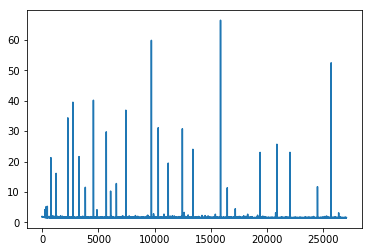

##### Smoothed Training Loss Curve

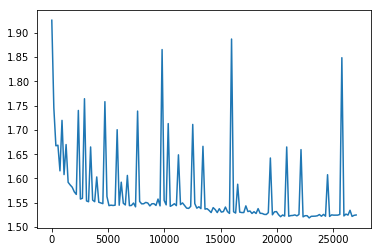

##### Smoothed and Zoomed Training Loss Curve

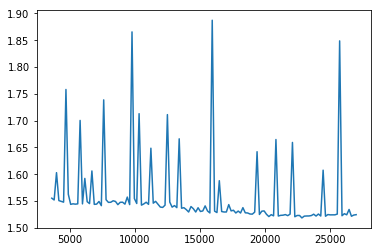

#### Test Error

* Baseline Loss: 1748.80

* Oracle Loss: 165.52

* Model Loss: 608.77

Prep type: norm1
Model cross comp
Num units: 100


### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

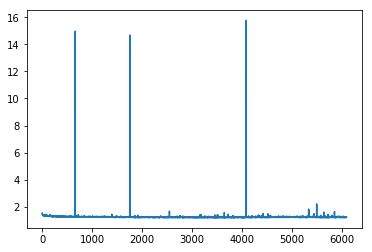

##### Smoothed Training Loss Curve

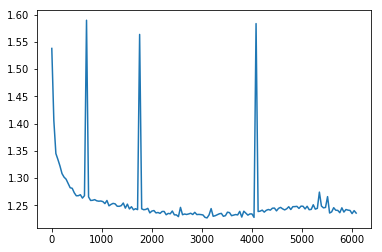

##### Smoothed and Zoomed Training Loss Curve

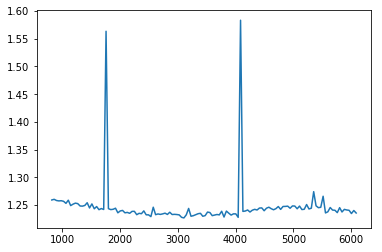

#### Test Error

* Baseline Loss: 1561.47

* Oracle Loss: 74.29

* Model Loss: 339.06

Prep type: norm1
Model cross comp
Num units: 100


### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

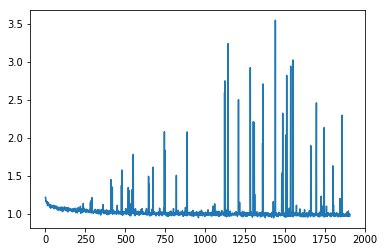

##### Smoothed Training Loss Curve

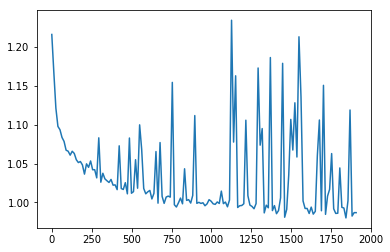

##### Smoothed and Zoomed Training Loss Curve

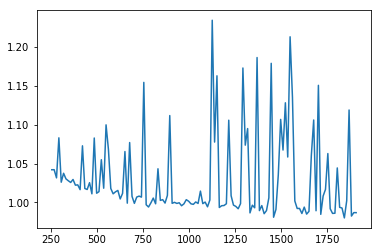

#### Test Error

* Baseline Loss: 1403.17

* Oracle Loss: 41.47

* Model Loss: 313.72

Add moved mass function after debugging bin script


## Experiment Summary: norm1_crossent_bet_unr

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Offer history normalized by difference between two most recent offers; no date or time features;number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm1
Model: Cross between
Num units: 100


### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

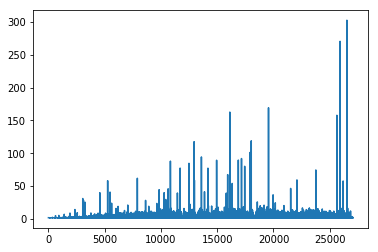

##### Smoothed Training Loss Curve

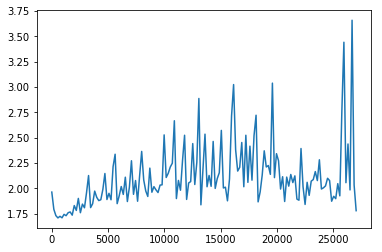

##### Smoothed and Zoomed Training Loss Curve

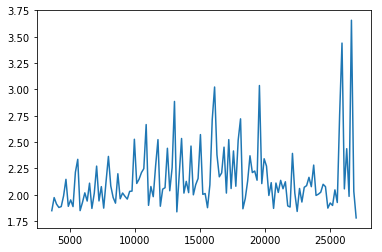

#### Test Error

* Baseline Loss: 1748.80

* Oracle Loss: 165.52

* Model Loss: 736.81

Prep type: norm1
Model: Cross between
Num units: 100


### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

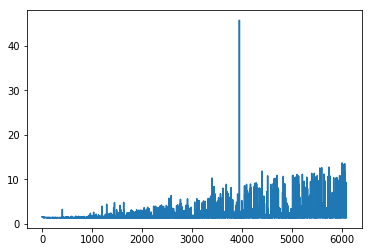

##### Smoothed Training Loss Curve

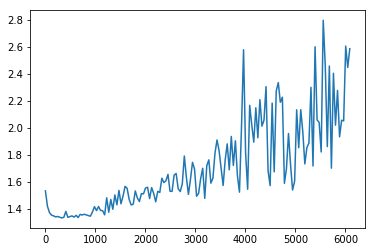

##### Smoothed and Zoomed Training Loss Curve

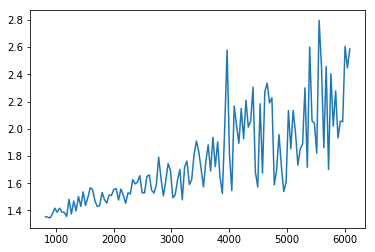

#### Test Error

* Baseline Loss: 1561.47

* Oracle Loss: 74.29

* Model Loss: 486.13

Prep type: norm1
Model: Cross between
Num units: 100


### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

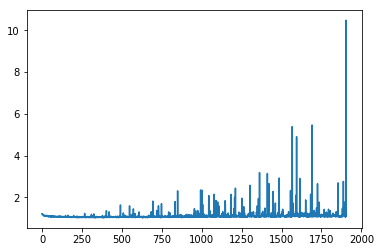

##### Smoothed Training Loss Curve

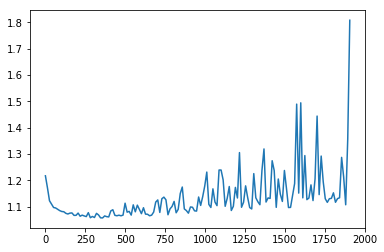

##### Smoothed and Zoomed Training Loss Curve

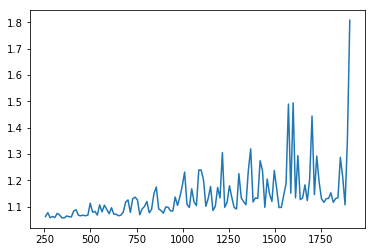

#### Test Error

* Baseline Loss: 1403.17

* Oracle Loss: 41.47

* Model Loss: 352.74

Add moved mass function after debugging bin script


## Experiment Summary: norm1_crossent_simp_unr

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Offer history normalized by difference between two most recent offers; no date or time features;number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm1
Model: Cross Simp
Num units: 30


### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

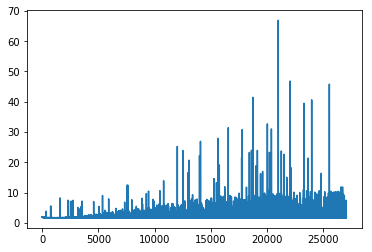

##### Smoothed Training Loss Curve

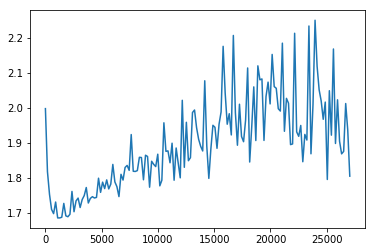

##### Smoothed and Zoomed Training Loss Curve

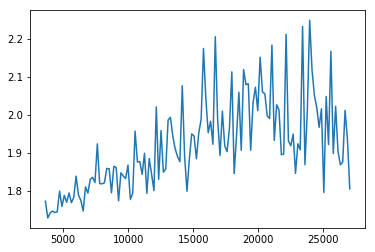

#### Test Error

* Baseline Loss: 1748.80

* Oracle Loss: 165.52

* Model Loss: 713.95

Prep type: norm1
Model: Cross Simp
Num units: 30


### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

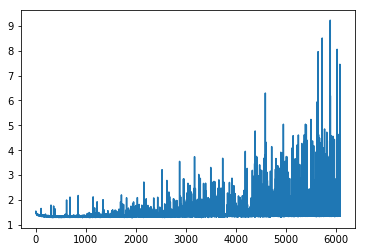

##### Smoothed Training Loss Curve

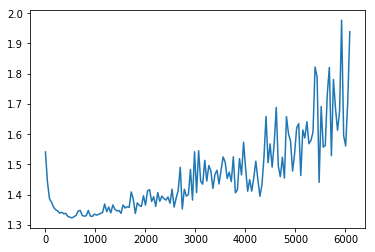

##### Smoothed and Zoomed Training Loss Curve

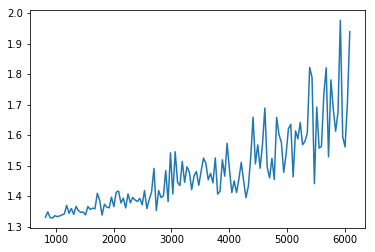

#### Test Error

* Baseline Loss: 1561.47

* Oracle Loss: 74.29

* Model Loss: 478.82

Prep type: norm1
Model: Cross Simp
Num units: 30


### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

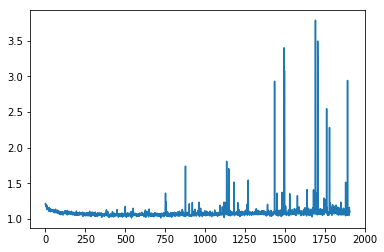

##### Smoothed Training Loss Curve

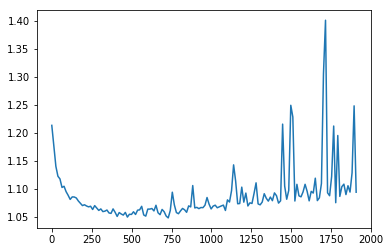

##### Smoothed and Zoomed Training Loss Curve

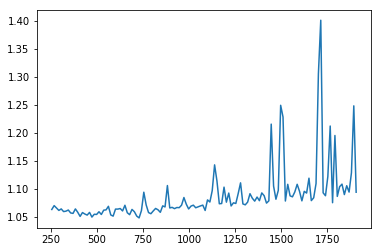

#### Test Error

* Baseline Loss: 1403.17

* Oracle Loss: 41.47

* Model Loss: 360.62

## Experiment Summary: norm1_exp_comp_unr

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Offer history normalized by difference between two most recent offers; no date or time features;number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm1
model exp comp
Num units: 100


### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

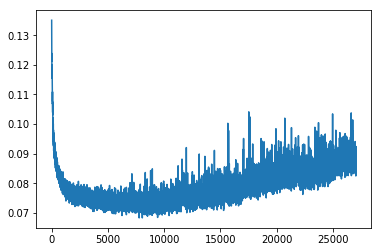

##### Smoothed Training Loss Curve

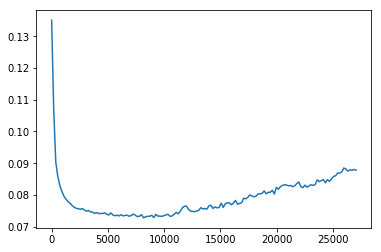

##### Smoothed and Zoomed Training Loss Curve

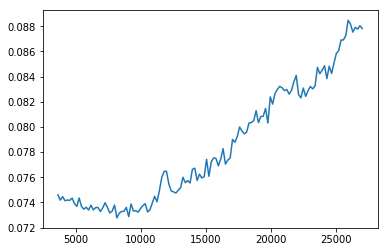

#### Test Error

* Baseline Loss: 1748.80

* Oracle Loss: 165.52

* Model Loss: 435.42

Prep type: norm1
model exp comp
Num units: 100


### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

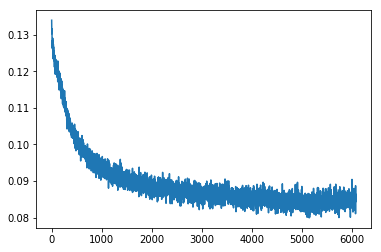

##### Smoothed Training Loss Curve

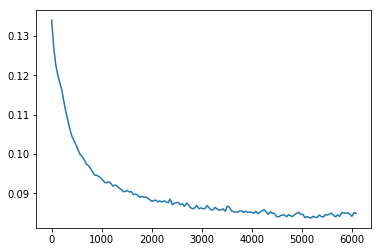

##### Smoothed and Zoomed Training Loss Curve

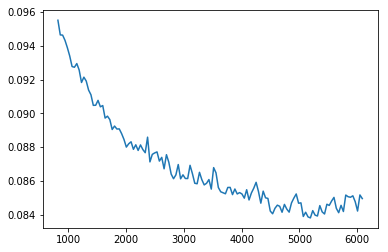

#### Test Error

* Baseline Loss: 1561.47

* Oracle Loss: 74.29

* Model Loss: 229.39

Prep type: norm1
model exp comp
Num units: 100


### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

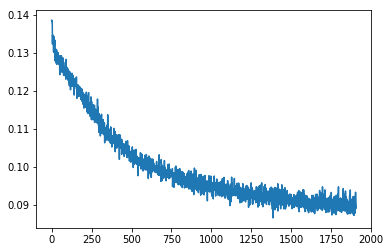

##### Smoothed Training Loss Curve

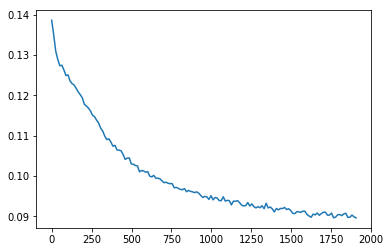

##### Smoothed and Zoomed Training Loss Curve

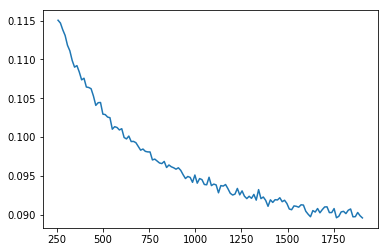

#### Test Error

* Baseline Loss: 1403.17

* Oracle Loss: 41.47

* Model Loss: 185.08

## Experiment Summary: norm1_exp_bet_unr

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Offer history normalized by difference between two most recent offers; no date or time features;number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm1
model exp between
Num units: 100


### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

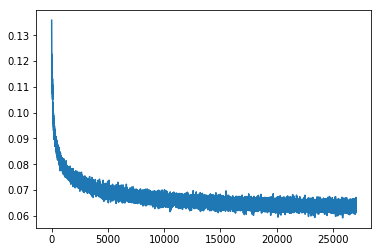

##### Smoothed Training Loss Curve

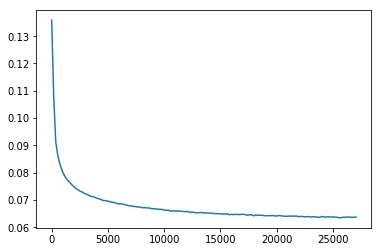

##### Smoothed and Zoomed Training Loss Curve

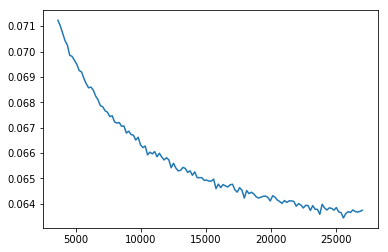

#### Test Error

* Baseline Loss: 1748.80

* Oracle Loss: 165.52

* Model Loss: 384.06

Prep type: norm1
model exp between
Num units: 100


### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

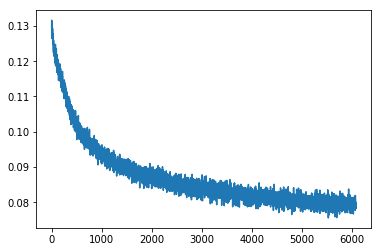

##### Smoothed Training Loss Curve

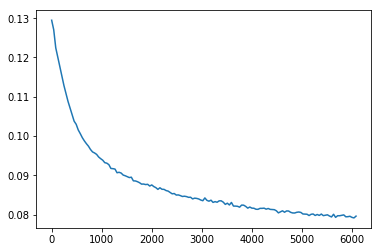

##### Smoothed and Zoomed Training Loss Curve

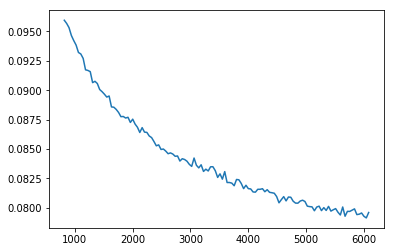

#### Test Error

* Baseline Loss: 1561.47

* Oracle Loss: 74.29

* Model Loss: 224.94

Prep type: norm1
model exp between
Num units: 100


### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

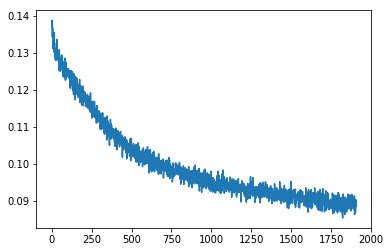

##### Smoothed Training Loss Curve

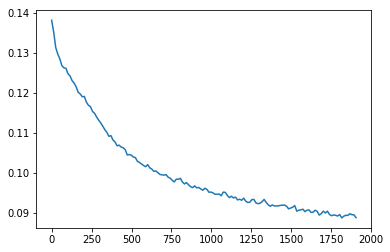

##### Smoothed and Zoomed Training Loss Curve

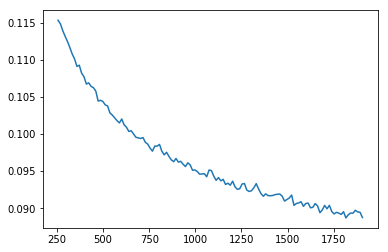

#### Test Error

* Baseline Loss: 1403.17

* Oracle Loss: 41.47

* Model Loss: 191.64

## Experiment Summary: norm1_exp_simp_unr

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Offer history normalized by difference between two most recent offers; no date or time features;number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm1
model exp simp
Num units: 30


### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

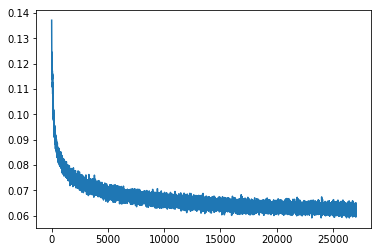

##### Smoothed Training Loss Curve

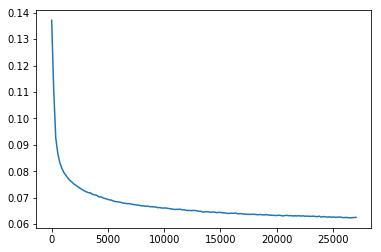

##### Smoothed and Zoomed Training Loss Curve

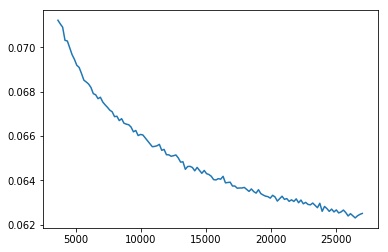

#### Test Error

* Baseline Loss: 1748.80

* Oracle Loss: 165.52

* Model Loss: 371.28

Prep type: norm1
model exp simp
Num units: 30


### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

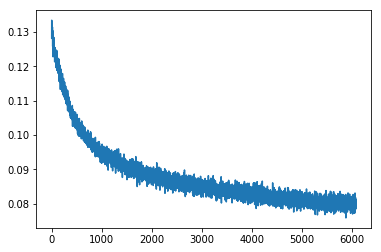

##### Smoothed Training Loss Curve

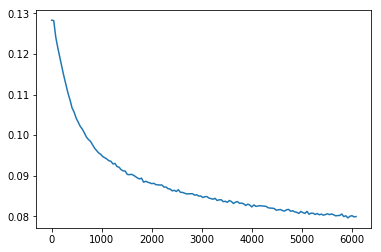

##### Smoothed and Zoomed Training Loss Curve

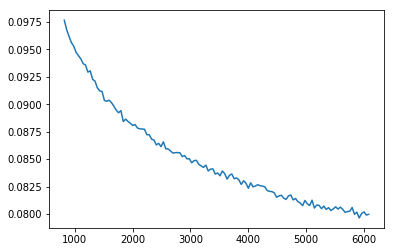

#### Test Error

* Baseline Loss: 1561.47

* Oracle Loss: 74.29

* Model Loss: 223.63

Prep type: norm1
model exp simp
Num units: 30


### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

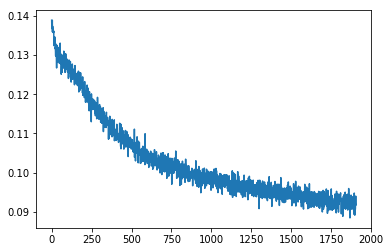

##### Smoothed Training Loss Curve

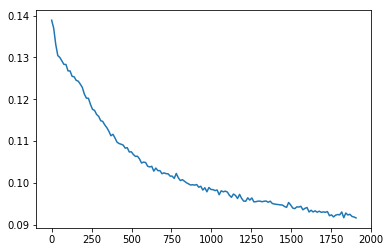

##### Smoothed and Zoomed Training Loss Curve

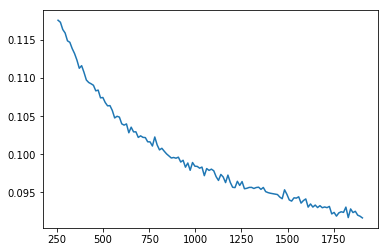

#### Test Error

* Baseline Loss: 1403.17

* Oracle Loss: 41.47

* Model Loss: 195.97

model|offr_s0|offr_s1|offr_s2
---|---|---|---
oracle|165.52267456054688|74.28985595703125|41.47066879272461
baseline|1748.7965087890625|1561.4678955078125|1403.17431640625
norm1_crossent_comp_unr|608.7738647460938|339.05548095703125|313.7248229980469
norm1_crossent_bet_unr|736.80859375|486.1258544921875|352.7353210449219
norm1_crossent_simp_unr|713.9549560546875|478.8205871582031|360.61761474609375
norm1_exp_comp_unr|435.4198303222656|229.39100646972656|185.08082580566406
norm1_exp_bet_unr|384.05657958984375|224.94032287597656|191.64456176757812
norm1_exp_simp_unr|371.282470703125|223.63343811035156|195.973388671875


In [22]:
main()